# **Task 2**
**Clustering**: In task 2 a new dataset will be introduced. The new dataset will be partially merged with the one obtained in feature engineering and preprocessing. The goal will be to create clusters made up of players with similar characteristics. The final partition will be used to scout young talents.

Imported libraries

In [1]:
import pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.feature import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import os


Creating the pyspark session

In [2]:
# Create the session
conf = SparkConf(). \
    set('spark.ui.port', "4050"). \
    set('spark.executor.memory', '15G'). \
    set('spark.driver.memory', '50G'). \
    set('spark.driver.maxResultSize', '40G'). \
    setAppName("PySparkProject"). \
    set('spark.executor.cores', "10"). \
    setMaster("local[*]")

sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

sc._conf.getAll()

[('spark.executor.memory', '15G'),
 ('spark.driver.host', 'LAPTOP-JLLVBEPM'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '50G'),
 ('spark.driver.port', '58077'),
 ('spark.app.startTime', '1685307478872'),
 ('spark.executor.cores', '10'),
 ('spark.app.name', 'PySparkProject'),
 ('spark.app.id', 'local-1685307480716'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.secur

## **Work on dataset begins**

Loading the new dataset and the dataset obtained from feature_engineering.ipynb

In [3]:
# Load cvs fifa23 dataset files pyspark
df = spark.read.csv("fifa23players.csv", header=True, inferSchema=True)

In [4]:
# Load csv dataset, obtained from the feature engineering and econdinf process
os.changedir('..')
df_ = spark.read.csv("dataset.csv", header=True, inferSchema=True)

### **Pre Processing Phase**

In [5]:
# Drop some df_ columns that are not useful for the task
df_ = df_.drop("clubs_id", "name", "competitions_id", "sub_position", "position", "citizenship", "current_club_id", "winning_rate_club", "winning_rate_pl", "games_lost_pl",
         "games_draw_pl", "games_won_pl", "appearances", "yellow_cards", "red_cards", "minutes_played", "goals", "assists", "height", "age", "market_value")

Filtering the dataset df_ : It must be composed by the instances whose date_v is in 2022. 

In [6]:
# delete the instances from df_ in which date_v is not in the year 2022
df_ = df_.filter(year(df_.date_v) == "2022")

Filtering the dataset df_ : for each player must be remain only the instance with date_v closest to 2022-06-15

In [8]:
# Define the reference date as "2022-06-15" using lit
target_date = lit("2022-06-15").cast("date")

# Compute the difference in days between date_v and the reference date
df_with_diff = df_.withColumn("date_diff", when(col("date_v") > target_date, col("date_v") - target_date)
                                 .otherwise(target_date - col("date_v")))

# Find the closest date to "2022-06-15" for each player_id
closest_date = df_with_diff.groupBy("player_id").agg(min("date_diff").alias("min_date_diff"))

# Join the original DataFrame with the DataFrame of the closest dates
df_ = df_with_diff.join(closest_date, on=["player_id"]).where(col("date_diff") == col("min_date_diff"))

# Remove the date_diff column if it is not necessary
df_ = df_.drop("date_diff", "min_date_diff")

In [9]:
# Remove (player_id, date_v) duplicates
df_ = df_.dropDuplicates(["player_id", "date_v"])

Removing the player_id with last_valuation equal to 0 (if their last_valuation is 0, they are probably not present in the fifa23players dataset)


In [10]:
# remove the player_id with last_valuation equal to 0
df_ = df_.filter(df_.last_valuation != 0)

Through the player_id key we get information about the players contained in player_id

In [11]:
# Load the cvs players to obtain some crucial information for the merge
df_players = spark.read.csv("archive/players.csv", header=True, inferSchema=True)

In [12]:
# join the two datasets on player_id
df_ = df_.join(df_players, on=["player_id"])

In [13]:
# drop some columns that are not useful for the task
df_ = df_.drop("current_club_id", "current_club_name", "country_of_birth", "city_of_birth", "foot", "height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "agent_name", "contract_expiration_date", "current_club_domestic_competition_id", "player_code", "image_url", "last_season", "url")

In [16]:
# drop duplicates on player_id
df = df.dropDuplicates(["player_id"])

We have to drop some not very useful features:

 .   ls
 ,  st
 ,  rs
 ,  lw
 ,  lf
 ,  cf
 ,  rf
 ,  rw
 ,  lam
 ,  cam
 ,  ram
 ,  lm
 ,  lcm
 ,  cm
 ,  rcm
 ,  rm
 ,  lwb
 ,  ldm
 ,  cdm
 ,  rdm
 ,  rwb
 ,  lb
 ,  lcb
 ,  cb
 ,  rcb
 , rb
 ,  gk
 ,  player_face_url
 ,  body_type
 ,  real_face
 ,  release_clause_eur
 ,  player_tags
 ,  player_traits
 ,  international_reputation
 ,  club_jersey_number
 ,  club_loaned_from
 ,  club_joined_date
 ,  club_contract_valid_until_year
 ,  nationality_id
 ,  nationality_name
 ,  nation_team_id
 ,  nation_position
 ,  nation_jersey_number
 ,  league_id
 ,  league_name
 ,  league_level
 ,  club_team_id
 ,  club_name
 ,  club_position
 ,  potential
 ,  value_eur
 ,  wage_eur
 ,  age
 ,  player_positions
 ,  player_id
 ,  player_url
 ,  fifa_version
 ,  fifa_update
 ,  fifa_update_date

We copy and paste, from the print schema method, the useless columns and we use regex to extract the name of each column

In [17]:
import re
str = "|-- ls: string (nullable = true)|-- st: string (nullable = true)|-- rs: string (nullable = true)|-- lw: string (nullable = true)|-- lf: string (nullable = true)|-- cf: string (nullable = true)|-- rf: string (nullable = true)|-- rw: string (nullable = true)|-- lam: string (nullable = true)|-- cam: string (nullable = true)|-- ram: string (nullable = true)|-- lm: string (nullable = true)|-- lcm: string (nullable = true)|-- cm: string (nullable = true)|-- rcm: string (nullable = true)|-- rm: string (nullable = true)|-- lwb: string (nullable = true)|-- ldm: string (nullable = true)|-- cdm: string (nullable = true)|-- rdm: string (nullable = true)|-- rwb: string (nullable = true)|-- lb: string (nullable = true)|-- lcb: string (nullable = true)|-- cb: string (nullable = true)|-- rcb: string (nullable = true)|-- rb: string (nullable = true)|-- gk: string (nullable = true)|-- player_face_url: string (nullable = true)|-- body_type: string (nullable = true)|-- real_face: string (nullable = true)|-- release_clause_eur: integer (nullable = true)|-- player_tags: string (nullable = true)|-- player_traits: string (nullable = true)|-- international_reputation: integer (nullable = true)|-- club_jersey_number: integer (nullable = true)|-- club_loaned_from: string (nullable = true)|-- club_joined_date: date (nullable = true)|-- club_contract_valid_until_year: integer (nullable = true)|-- nationality_id: integer (nullable = true)|-- nation_team_id: integer (nullable = true)|-- nation_position: string (nullable = true)|-- nation_jersey_number: integer (nullable = true)|-- league_id: integer (nullable = true)|-- league_name: string (nullable = true)|-- league_level: integer (nullable = true)|-- club_team_id: integer (nullable = true)|-- club_name: string (nullable = true)|-- club_position: string (nullable = true)|-- potential: integer (nullable = true)|-- value_eur: integer (nullable = true)|-- wage_eur: integer (nullable = true)|-- age: integer (nullable = true)|-- player_positions: string (nullable = true)|-- player_id: integer (nullable = true)|-- player_url: string (nullable = true)|-- fifa_version: integer (nullable = true)|-- fifa_update: integer (nullable = true)|-- fifa_update_date: date (nullable = true)"
pattern = pattern = r"(?<=- ).*?(?=: )"
elements_to_drop = re.findall(pattern, str)

In [18]:
for element in elements_to_drop:
    df = df.drop(element)

Merging the fifa dataset and the dataset obtained in feature_engineering.ipynb:
in this case the difficulty is finding the parameters on which to join. We have opted in the union on the couple (date of birth, nationality)

In [19]:
# join df and df_ in which df.dob == df_.date_of_birth and df_.country_of_citizenship == df.nationality_name
joined_df = df.join(df_, (df.dob == df_.date_of_birth) & (df_.country_of_citizenship == df.nationality_name))

In [20]:
# count the number of distinct player_id
#print(joined_df.select("player_id").distinct().count())
# count the number of rows
#print(joined_df.count())

Removing from df the player_id that occurre more than once

In [21]:
count_df = joined_df.groupBy("player_id").agg(count("*").alias("count"))
df = joined_df.join(count_df, "player_id").filter(count_df["count"] == 1).drop("count") # we will add to df the instances obtained from the filtered df 
#print(df.select("player_id").distinct().count())

filtered_df is composed of instances of player_id that appear in df more than once: in particular filtered_df is composed of the players for whom the union (date of birth, nationality) does not work because there is more than one instance for which the key tuple (date of birth, nationality) is valid

In [22]:
# dataset composed by the instances with player_id not unique (i.e. that appears more than once)
count_df = joined_df.groupBy("player_id").agg(count("*").alias("count"))
filtered_df = joined_df.join(count_df, "player_id").filter(count_df["count"] > 1).drop("count")

Since, for these instances, (date of birth, nationality) does not work, we decide to perform the filter through long_name (fifa dataset) and name (the other dataset)

In [23]:
# mantain only the instance in which long name is equal to name
filtered_df = filtered_df.filter(filtered_df.long_name == filtered_df.name)

Adding to df the unique instances of filtered_df that we managed to extract

In [24]:
# add to df the instances of filtered_df
df = df.union(filtered_df)

In [25]:
# check if there are still duplicates
# print(df.count())
# print(df.select("player_id").distinct().count())

In [26]:
# INSERT CURRENT DATE #
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

Adding to the dataset the feature age

In [27]:
# add to the df the column age
df = df.withColumn("age", floor(datediff(lit(current_date), "dob")/365))

In [31]:
# drop some columns
df = df.drop("first_name", "date_birth", "last_name", "date_of_birth", "date_v", "country_of_citizenship", "dob", "short_name", "long_name")

### **Feature Engineering Phase**

In [33]:
# for each features of df, check if there are null values
# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+-------+---------+---------+----------------+--------------+---------+-----------+---------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+--------------+-----------------+--------------+---------------+---------------+----+--------+------------+---+
|player_id|overall|height_cm|weight_kg|natio

Fixing null value and zero value

In [34]:
# if position is goal keeper then club_position = GK then set pace, shooting, passing, dribbling, defending, physic = 0
df = df.withColumn("pace", when(df.position == "Goalkeeper", 0).otherwise(df.pace))
df = df.withColumn("shooting", when(df.position == "Goalkeeper", 0).otherwise(df.shooting))
df = df.withColumn("passing", when(df.position == "Goalkeeper", 0).otherwise(df.passing))
df = df.withColumn("dribbling", when(df.position == "Goalkeeper", 0).otherwise(df.dribbling))
df = df.withColumn("defending", when(df.position == "Goalkeeper", 0).otherwise(df.defending))
df = df.withColumn("physic", when(df.position == "Goalkeeper", 0).otherwise(df.physic))

In [35]:
# if the sub_position is null, set it to position value
df = df.withColumn("sub_position", when(col("sub_position").isNull(), col("position")).otherwise(col("sub_position")))

In [36]:
# if position is not Goalkeeper then set goalkeeping_speed to 0
df = df.withColumn("goalkeeping_speed", when(df.position != "Goalkeeper", 0).otherwise(df.goalkeeping_speed))

If the fixes didn't work, it means that the instances involved are originally wrong. Then we decided to drop it

In [37]:
# remove the instances in which there are null values
#print(df.count())
df = df.na.drop()
#print(df.count())

In [38]:
print(df.count())
# count the number of distinct player_id
print(df.select("player_id").distinct().count())

4391
4391


Saving the dataset obtained from the pre-processing, feature engineering and merging operations

In [ ]:
import pandas as pd
df_p = df.toPandas()
df_p.to_csv("talent_scouting/task2dataset.csv", index=False)

## **Clustering algorithm applications: k-means** 

Loading the dataset obtained from the previous phases

In [3]:
# load the dataset obtained in the previous phases
df = spark.read.csv("talent_scouting/task2dataset.csv", header=True, inferSchema=True)

Converting double features to avoid problem in the next steps and to make all the numerical features of the same type

In [4]:
# convert from double to int the features goalkeeping_speed, pace, shooting, passing, dribbling, defending, physic
df = df.withColumn("goalkeeping_speed", df.goalkeeping_speed.cast("int"))
df = df.withColumn("pace", df.pace.cast("int"))
df = df.withColumn("shooting", df.shooting.cast("int"))
df = df.withColumn("passing", df.passing.cast("int"))
df = df.withColumn("dribbling", df.dribbling.cast("int"))
df = df.withColumn("defending", df.defending.cast("int"))
df = df.withColumn("physic", df.physic.cast("int"))
df = df.withColumn("mentality_composure", df.mentality_composure.cast("int"))

In [5]:
# drop column player_id
df = df.drop("games_played_club", "games_won_club", "games_draw_club", "games_lost_club")

Since nationality is not a crucial feature for our task, and furthermore, in the case of applying one hot encoding, it would greatly increase the number of features, we decided to exclude it from the dataset


In [6]:
# drop the features nationality_name and name
dfc = df.drop("nationality_name", "name")

Creating a feature copy of age

In [7]:
# crea una copia della feature age in age_copy
dfc = dfc.withColumn("age_copy", dfc.age)

### **Standardization of the numerical features**

In [8]:
def standardize(dfc):
    assembler = VectorAssembler(inputCols=list(set(dfc.columns) - set(["player_id", "preferred_foot", "work_rate", "position", "sub_position", "age_copy"])), 
                                outputCol="features")

    dfc = assembler.transform(dfc)

    scaler = StandardScaler(inputCol="features", 
                            outputCol="scaled_features",
                            withStd=True, withMean=True)

    # fitting the StandardScaler
    scalerModel = scaler.fit(dfc)

    # Normalize each feature
    dfc = scalerModel.transform(dfc)
    return dfc

In [9]:
dfc = standardize(dfc)

In [10]:
dfc = dfc.drop(*list(set(df.columns) - set(["player_id", "preferred_foot", "work_rate", "position", "sub_position", "age_copy"])))

### **Applying one-hot encoding of the categorical features**

In [11]:
def apply_one_hot_encoding(df, column_names, df_id):

    def generate_encoded_columns(df, name_column, column_values):
        return [
            when(df[name_column].isin(value), 1).otherwise(0).alias(f"{name_column}_{value}")
            for value in column_values
        ]
    
    diz = {}
    for col in column_names:
        diz[col]=[row[col] for row in df.select(col).distinct().collect()] # creating a dictionary with the column name as key and the list of values as value (distinct values)

    encoded_columns = []
    for name_column, column_values in diz.items():
        encoded_columns.extend(generate_encoded_columns(df, name_column, column_values)) # called the function to generate the encoded columns
    encoded_df = df.select(df_id, *encoded_columns)
    #join the encoded df with the original df on the key df_id
    df = df.join(encoded_df, df_id)
    #drop the columns in column_names
    df = df.drop(*column_names)
    return df

In [12]:
column_names = ["preferred_foot", "work_rate", "position", "sub_position"] #columns to apply one hot encoding (categorical features)
dfc = apply_one_hot_encoding(dfc, column_names, "player_id") # apply one hot encoding to the specified columns on the df id player_id

### **NO PCA! Assemble the features of dfc**

This function allows to assemble the dataset for the k-means if we wanto to apply pca

In [13]:
def dataset_assembler(df): 
   # Crea un'istanza di VectorAssembler specificando le colonne di input e la colonna di output
    assembler = VectorAssembler(inputCols=list(set(df.columns) - set(["player_id", "features"])), outputCol="pcaFeatures")

    # Applica il VectorAssembler al DataFrame
    df_pca = assembler.transform(df)
    return df_pca

### **Principal Component Analysis: PCA**

Using the method of explained variance. The method of explained variance is a statistical technique used to understand the amount of information or variability in a dataset that is captured or "explained" by each principal component. Here are the algorithmic steps:
- Apply PCA to the dataframe with a large k value, in our case k is equal to the number of features of the dataframe;
- Get the variance explained by each principal component using the 'explainedVariance' method of the PCA model;
- Calculate the total variance by adding up all the explained variances;
- Calculates the percentage of variance explained by each principal component by dividing the explained variance of each component by the total variance;
- Calculates the cumulative variance, which is the cumulative sum of the percentages of explained variance;
- Select a desired value of percentage of total variance to explain, in our case 95%;
- Find the smallest value of k such that the cumulative variance exceeds or equals the desired percentage;
- k will be the number of components.

In [14]:
def get_optimal_k(df, desired_variance_percentage, k):
    
    assembler = VectorAssembler(inputCols=list(set(df.columns) - set(["player_id", "features", "age_copy"])), outputCol="features_")
    df_assembled = assembler.transform(df)

    pca = PCA(k=k, inputCol="features_", outputCol="pcaFeatures")
    model = pca.fit(df_assembled)

    explained_variance = model.explainedVariance.toArray() # returns a numpy.ndarray to calculate the total variance
    total_variance = np.sum(explained_variance) # sum of the explained variance

    cumulative_variance = 0.0
    num_selected_features = 0

    for variance in explained_variance:
        cumulative_variance += variance
        num_selected_features += 1
        if cumulative_variance >= desired_variance_percentage * total_variance:
            break

    return num_selected_features

Applying PCA to decrease the number of features

In [15]:
def apply_PCA(df, features_name_list, k):

    assembler = VectorAssembler(inputCols=features_name_list, outputCol="features_")
    df_assembled = assembler.transform(df)
    pca = PCA(k=k, inputCol="features_", outputCol="pcaFeatures")
    model = pca.fit(df_assembled)
    df_pca = model.transform(df_assembled).select("player_id", "pcaFeatures")
    
    return df_pca

This function prepares the dataset to k-means:
- if the flag is true, then apply the pca
- if the flag is false, then assemble the dataset

In [16]:
def flag_PCA(df,flag): # if flag is True, apply PCA, otherwise apply assembler
    if flag is True:
        desired_variance_percentage = 0.95
        k = len(list(set(df.columns) - set(["player_id", "features", "age_copy"]))) + len(dfc.first()["scaled_features"])
        optimal_k = get_optimal_k(df, desired_variance_percentage, k-1)
        print("I'm applying pca with an optimal k= ", optimal_k)
        df_pca = apply_PCA(df, list(set(df.columns)-{"player_id", "features", "age_copy"}), optimal_k)
    else:
        df_pca = dataset_assembler(df)
        print("I'm not applying pca, but i'm assembling the dataset for k-means")
    return df_pca

### **Applying k-means** 

In [17]:
RANDOM_SEED = 42

In [18]:
def k_means(dataset, n_clusters, distance_measure="euclidean", max_iter=80, features_col="pcaFeatures", prediction_col="cluster", random_seed=RANDOM_SEED):
  
    print("""k-means parameters: - number of clusters = {:d} - max iterations = {:d} - distance measure = {:s} - random seed = {:d}""".format(n_clusters, max_iter, distance_measure, random_seed))

    # train a k-means model
    kmeans = KMeans(featuresCol=features_col, 
                    predictionCol=prediction_col, 
                    k=n_clusters, 
                    initMode="k-means||", # or random
                    initSteps=10, 
                    tol=0.0000001, 
                    maxIter=max_iter, 
                    seed=random_seed, 
                    distanceMeasure=distance_measure)
    model = kmeans.fit(dataset)

    clusters_df = model.transform(dataset) # obtain new df with the cluster column (prediction_col)

    return model, clusters_df

In [19]:
def evaluate_k_means(clusters, metric_name="silhouette", distance_measure="squaredEuclidean",prediction_col="cluster"):
  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure, 
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [20]:
def applying_elbow(df, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=100, random_seed=RANDOM_SEED):        

    clustering_results = {} # dictionary to store the results of the clustering (key=k, value=silhouette)
    k_values = range(min_k, max_k) # range of k values to try

    silhouette_values = []

    for k in k_values:
        # Creazione dell'istanza del modello K-means
        model, clusters_df = k_means(df, k, features_col="pcaFeatures", prediction_col=prediction_col, random_seed=RANDOM_SEED)
        clusters_df = clusters_df.withColumn("features", clusters_df["pcaFeatures"])

        # Calcolo del SSE (Sum of Squared Errors)
        silhouette = evaluate_k_means(clusters_df)
        silhouette_values.append(silhouette)
        clustering_results[k] = silhouette

    # Plot del grafico SSE vs. Valori k
    plt.plot(k_values, silhouette_values, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    return clustering_results

Split dfc in dfc1, composed by player with age >25, and dfc2, composed by player with age <=25

**dfc1 is made up of players who are over 25 years old**

**dfc2 is made up of players who are under 25 years old**

In [21]:
# split dfc in two dataframes: one composed of player with age >26, the other composed of player with age <=26
def split_dataframe(dfc):
    dfc1 = dfc.filter(dfc.age_copy > 25)
    dfc2 = dfc.filter(dfc.age_copy <= 25)
    return dfc1, dfc2

In [22]:
dfc1, dfc2 = split_dataframe(dfc)

In this case,  we apply k-means, then our categorical features are processed by one hot encoding, then we can apply PCA (flag = True)

In [23]:
df1_pca = flag_PCA(dfc1,flag=True)
df2_pca = flag_PCA(dfc2,flag=True)

I'm applying pca with an optimal k=  21
I'm applying pca with an optimal k=  25


k-means parameters: - number of clusters = 60 - max iterations = 80 - distance measure = euclidean - random seed = 42


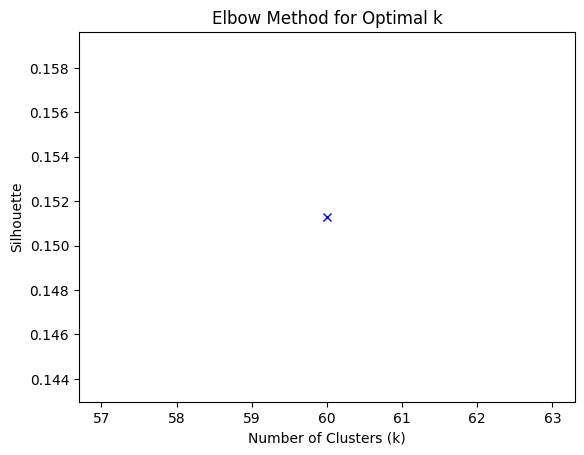

k-means parameters: - number of clusters = 60 - max iterations = 80 - distance measure = euclidean - random seed = 42


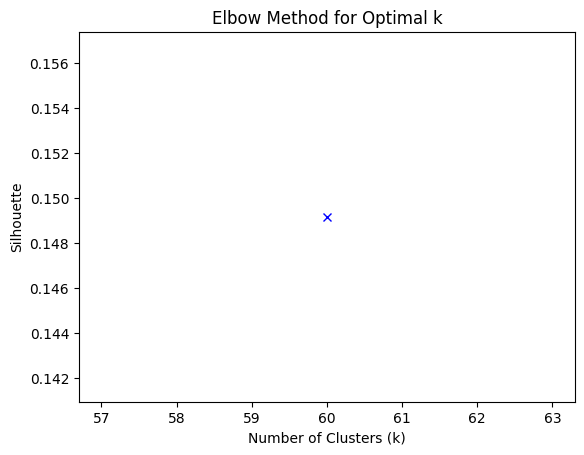

In [24]:
# def applying_elbow(df, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=100, random_seed=RANDOM_SEED):
clustering_results1 = applying_elbow(df1_pca, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=61, random_seed=RANDOM_SEED)
clustering_results2 = applying_elbow(df2_pca, features_col="pcaFeatures", prediction_col="cluster", min_k=60, max_k=61, random_seed=RANDOM_SEED)

In [25]:
# obtain the key of the max items of clustering_results
k_clustering1 = list(dict(sorted(clustering_results1.items(), key=lambda item: item[1], reverse=True)))[0]
k_clustering2 = list(dict(sorted(clustering_results2.items(), key=lambda item: item[1], reverse=True)))[0]

In [26]:
model1, df_clusters1 = k_means(df1_pca, k_clustering1, features_col="pcaFeatures", prediction_col="cluster", random_seed=RANDOM_SEED) # k_clustering or we can choose the number of clusters
model2, df_clusters2 = k_means(df2_pca, k_clustering2, features_col="pcaFeatures", prediction_col="cluster", random_seed=RANDOM_SEED) # k_clustering or we can choose the number of clusters

k-means parameters: - number of clusters = 60 - max iterations = 80 - distance measure = euclidean - random seed = 42
k-means parameters: - number of clusters = 60 - max iterations = 80 - distance measure = euclidean - random seed = 42


In [27]:
df_clusters1 = df_clusters1.withColumn("features", df_clusters1["pcaFeatures"]) # we need to do this because the function evaluate_k_means needs a column named "features"
df_clusters2 = df_clusters2.withColumn("features", df_clusters2["pcaFeatures"]) # we need to do this because the function evaluate_k_means needs a column named "features"
silhouette1 = evaluate_k_means(df_clusters1, metric_name="silhouette", distance_measure="squaredEuclidean", prediction_col="cluster")
silhouette2 = evaluate_k_means(df_clusters2, metric_name="silhouette", distance_measure="squaredEuclidean", prediction_col="cluster")

In [28]:
print(silhouette1)
print(silhouette2)

0.15128832185462018
0.14916693012798857


Joining the initial dataframe and the k-means resulting dataframe

In [29]:
#join the clusters_df with the original df on the key player_id
df_k_means1 = df.join(df_clusters1, "player_id")
df_k_means2 = df.join(df_clusters2, "player_id")

In [30]:
#oridinare df_k_means per cluster
df_k_means1 = df_k_means1.orderBy("cluster")
df_k_means2 = df_k_means2.orderBy("cluster")

Drop weight_kg, nationality_name, work_rate pcaFeatures, features

Remove useful columns in df_k_means1 and df_k_means2

In [31]:
# def funtion to remove columns in df_k_means1 and df_k_means2
def remove_columns(df_k_means):
    # drop pcaFeatures, features
    df_k_means = df_k_means.drop("pcaFeatures")
    df_k_means = df_k_means.drop("features")
    df_k_means = df_k_means.drop("nationality_name")
    df_k_means = df_k_means.drop("work_rate")
    df_k_means = df_k_means.drop("weight_kg")
    return df_k_means

In [32]:
df_k_means1 = remove_columns(df_k_means1)
df_k_means2 = remove_columns(df_k_means2)

## **Football players cluster scouting**

The clustering algorithm used grouped similar players together. From now on we could think of using the obtained partition in various ways, in particolar, input a player_id and find a cluster made up of similar players with a lower average age

### **Implementation of the first of the two method to get the cluster for the input player**

This method returns always one cluster. It does not allow the manipulation of the hyperparameters.
The problem with this method is that it tends to look for a cluster containing players with similar stat values ​​to the input player. The method implemented subsequently is able to search for clusters that contain players with values ​​even lower than those of the player given in input.

This function is used to create:
- a dictionary with the stats of the input player (player_id)
- a list of dictionary with the average stats of the clusters

In [33]:
'''
def search_cluster(df1, df2, player_id): #player_id is related to df1

    # insert in a dictionaty all the values of player_id of df1 except player_id, name, age, cluster
    player_id_dict = {}
    for column in df1.columns:
        if column not in ["player_id", "name", "age", "cluster"]:
            values = df1.filter(col("player_id") == player_id).select(col(column)).collect()
            player_id_dict[column] = values[0][0] if len(values) > 0 else None
    
    clusters_value = []
    no_cluster = df2.select(col("cluster")).distinct().count()
    for i in range(no_cluster):
        # filter the rows where the column "cluster" is equal to i
        df_filtered = df2.filter(col("cluster") == i)
        col_to_drop = ["player_id", "name", "age", "cluster"]
        df_filtered = df_filtered.drop(*col_to_drop)
        clus_values = {}

        # Itera su ogni colonna nel DataFrame
        for column in df_filtered.columns:
            if column not in ["player_id", "name", "age", "cluster"]:
                # check if the column is numeric or not
                if df_filtered.schema[column].dataType in [IntegerType(), FloatType()]:
                    # compute the mean of the column
                    avg = df_filtered.select(mean(col(column))).collect()[0][0]
                    clus_values[column] = avg
                else:
                    # Calcola il valore che appare maggiormente nella colonna non numerica
                    max_value = df_filtered.groupBy(column).count().orderBy(desc("count")).first()[column]
                    clus_values[column] = max_value

        clusters_value.append(clus_values)

    return player_id_dict, clusters_value
'''

def search_cluster(df1, df2, player_id): #player_id is related to df1
    pdf1 = df1.filter(col("player_id") == player_id).toPandas()
    pdf2 = df2.toPandas()

    player_id_dict = pdf1.drop(columns=["player_id", "name", "age", "cluster"]).iloc[0].to_dict() # we need to drop the columns that we don't need

    unique_clusters = pdf2["cluster"].unique()
    clusters_value = []

    for cluster in unique_clusters:
        # Filter the rows where the column "cluster" is equal to the current cluster value
        pdf_filtered = pdf2[pdf2["cluster"] == cluster]
        pdf_filtered = pdf_filtered.drop(columns=["player_id", "name", "age", "cluster"])

        # Calculate the mean values for the numeric columns and the mode for the non-numeric columns
        clus_values = pdf_filtered.mean(numeric_only=True).to_dict() # create the dictionary for the current cluster inserting the mean values of the numeric columns
        non_numeric_columns = pdf_filtered.select_dtypes(exclude=["number"]).columns # obtain the list of the non-numeric columns

        for column in non_numeric_columns:
            clus_values[column] = pdf_filtered[column].mode()[0] # insert the mode value of the non-numeric column in the dictionary

        clusters_value.append(clus_values)

    return player_id_dict, clusters_value

This function returns the index of the cluster with the most similar player

In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder

def find_most_similar_index(d, dlist): # given a dictionary and a list of dictionaries, find the index of the most similar dictionary in the list (with respect of dictionary d)
    categorical_keys = [key for key, value in d.items() if isinstance(value, str)]
    numeric_keys = [key for key in d if key not in categorical_keys]

    # Convert the categorical attributes into one-hot encoding
    encoder = OneHotEncoder(sparse=False, handle_unknown="ignore") #sparse=False because we want all the values in the matrix, handle_unknown="ignore" because we don't want to raise an error if we find a new value
    categorical_values = encoder.fit_transform([[d[key]] for key in categorical_keys])

    # We have to create vector and a list of vectors to use the cosine_similarity function
    vectors = []
    for d_dict in dlist:
        numeric_values = [d_dict.get(key, 0.0) for key in numeric_keys]
        cat_values = categorical_values.flatten().tolist()
        vector = numeric_values + cat_values
        vectors.append(vector)

    vector = [d.get(key, 0.0) for key in numeric_keys] + categorical_values.flatten().tolist()

    # Calculate the cosine similarity between the vectors
    similarities = cosine_similarity(vectors, [vector])
    most_similar_index = np.argmax(similarities)
    return most_similar_index


In [35]:
# PLAYER ID # insert the id of the player for whom we want to search for similar younger players
player_id = 133964 #88755
player_id_dict, clusters_value = search_cluster(df_k_means1, df_k_means2, player_id)

In [37]:
result_playerid = df_k_means1.filter(df_k_means1.player_id == player_id)

Create copies of the list and of the player dictionary, and remove the keys ["overall", "weak_foot", "pace", "shooting", "dribbling", "defending", "physic"] from the dictionary beacuse the search will be not based on these values

In [38]:
import copy
player_id_dict_copy = copy.deepcopy(player_id_dict)
clusters_value_copy = copy.deepcopy(clusters_value)
keys_to_remove = ["overall", "weak_foot", "pace", "shooting", "dribbling", "defending", "physic", "last_valuation"]

for key in keys_to_remove:
    del player_id_dict_copy[key]

for i in range(len(clusters_value_copy)):
    for key in keys_to_remove:
        del clusters_value_copy[i][key]

In [39]:
if df_k_means2.filter(col("cluster") == 0).count() > 0:
    cluster_index = find_most_similar_index(player_id_dict_copy, clusters_value_copy)
else:
    cluster_index = find_most_similar_index(player_id_dict_copy, clusters_value_copy) + 1

c:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [40]:
print("output cluster index first algorithm:")
print(cluster_index)

output cluster index first algorithm:
35


Show the cluster (cluster_index)

In [41]:
result1 = df_k_means2.filter(col("cluster") == int(cluster_index))

### **Implementation of a more precise method to get the clusters for the input player**

This method returns a list of similar cluster. It can return an empty list. It allows the manipulation of the hyperparameters

In [42]:
key_list = []
for k,v in player_id_dict.items():
    key_list.append(k)

In [43]:
# remove: overall, height_cm, skill_moves, pace, shooting, dribbling, defending, physic from key_list
key_list = list(set(key_list) - set(["overall", "weak_foot", "pace", "shooting", "dribbling", "defending", "physic"]))

Remove the keys ["overall", "weak_foot", "pace", "shooting", "dribbling", "defending", "physic"] from the dictionary beacuse the search will be not based on these values

In [44]:
import copy
player_id_dict_c = player_id_dict.copy()
clusters_value_c = copy.deepcopy(clusters_value)
keys_to_remove = ["overall", "weak_foot", "pace", "shooting", "dribbling", "defending", "physic"]

for key in keys_to_remove:
    del player_id_dict_c[key]

for i in range(len(clusters_value_c)):
    for key in keys_to_remove:
        del clusters_value_c[i][key]

Function to get the list of the clusters with players similar to one given in input.

1. For each cluster in the list of clusters:
    - Check if the cluster has the same position, sub position, and preferred foot as the player.
    - Check if the cluster has a height that does not differ by more than 10 cm from the player.
    - Check if the cluster has an average last valuation between min_value and max_value
    - Check if the cluster has a skill moves that does not differ by more than 2 points from the player.


2. Sort the keys of the player in descending order by values.

3. For each cluster in the list of clusters:
    - Sort the keys of the cluster in descending order by values.


4. Return the clusters that have the same first x values as those of the player.


In [45]:
import math

min_value = 5000000 
max_value = 50000000

def get_clus(player_dict, clusters_list): # return the list of the clusters for the player of player_dict
    player_dict_c = copy.deepcopy(player_dict)
    clusters_list_c = copy.deepcopy(clusters_list)

    clus_list_first = [] # dictionary that have passed the first filter

    # first filter
    for i in range(len(clusters_list_c)):
        if clusters_list_c[i]["position"] == player_dict_c["position"] and clusters_list_c[i]["sub_position"] == player_dict_c["sub_position"] and clusters_list_c[i]["preferred_foot"] == player_dict_c["preferred_foot"]:
            height_diff = int(clusters_list_c[i]["height_cm"]) - int(player_dict_c["height_cm"])
            skills_diff = int(clusters_list_c[i]["skill_moves"]) - int(player_dict_c["skill_moves"])
            if math.sqrt(height_diff**2) < 20 and math.sqrt(skills_diff**2) <= 2 and int(clusters_list_c[i]["last_valuation"]) <= max_value and int(clusters_list_c[i]["last_valuation"]) >= min_value:
                clus_list_first.append((i,clusters_list_c[i]))

    # delete from clus_list_first and player_dict_c keys height_cm, skill_moves, last_valuation, position, sub_position, preferred_foot

    keys_todelete = ["height_cm", "skill_moves", "last_valuation", "position", "sub_position", "preferred_foot"]

    for clus in clus_list_first:
        for key in keys_todelete:
            del clus[1][key]
    #print(clus_list_first)

    # delete from player_dict_c keys height_cm, skill_moves, last_valuation, position, sub_position, preferred_foot
    for key in keys_todelete:
        del player_dict_c[key]

    # sort the player_dict_c keys based on the values
    sorted_keys_player_id = sorted(player_dict_c, key=player_dict_c.get, reverse=True)
    #print(sorted_keys_player_id)

    # sort the clusters based on the values
    sorted_keys_clusters = []
    for clus in clus_list_first:
        sorted_keys_clusters.append((clus[0], sorted(clus[1], key=clus[1].get, reverse=True)))
    #print(sorted_keys_clusters)

    # filter the filtered clusters based on the remaining stats value
    list_to_return = []
    for clus in sorted_keys_clusters:
        if len(list((set(sorted_keys_player_id[:10])) & (set(clus[1][:10])))) > 4:
            list_to_return.append(clus[0])

    return list_to_return

In [46]:
l = get_clus(player_id_dict_c, clusters_value_c)

15
32


In [47]:
print("output cluster index second algorithm:")
print(l[0])

output cluster index second algorithm:
15


Show the first cluster of the list. The list can be empty.

In [48]:
result2 = df_k_means2.filter(col("cluster") == l[0])

Creating the dictionaries of the player_id and of the two clusters

In [49]:
column_names = result_playerid.columns
diz_result_playerid = {column: value for column, value in zip(column_names, result_playerid.first())}

In [50]:
def from_df_to_dict(df):
    # Convert the DataFrame into a list of rows using collect()
    rows = df.collect()

    # Define the function for the row processing
    def process_row(row):
        column_names = row.__fields__
        row_dict = {column: getattr(row, column) for column in column_names}
        l_diz_result.append(row_dict)

    # Initialize the list for the results
    l_diz_result = []

    # Function application to each row
    for row in rows:
        process_row(row)
    return l_diz_result

In [51]:
l_diz_result1 = from_df_to_dict(result1)
l_diz_result2 = from_df_to_dict(result2)

In [52]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def sort_dicts(diz, ldiz):
    del diz["player_id"]
    del diz["cluster"]

    # Creation of the list of unique keys
    keys = set(diz.keys())
    for ld in ldiz:
        keys.update(ld.keys())

    for el in ldiz:
        del el["player_id"]
        del el["cluster"]
    
    # Creation of the extended one-hot matrices for the reference dictionary (diz) and the dictionaries in the list (ldiz)
    diz_matrix = create_extended_one_hot_matrix(diz, keys)
    ldiz_matrices = [create_extended_one_hot_matrix(ld, keys) for ld in ldiz]
    
    # Calculate the cosine similarities between the reference dictionary and the dictionaries in the list
    similarities = [cosine_similarity(diz_matrix, ld_matrix)[0][0] for ld_matrix in ldiz_matrices]

    # Sort the dictionaries in the list based on the similarities
    sorted_ldiz = [ld for _, ld in sorted(zip(similarities, ldiz), reverse=True)]
    
    return sorted_ldiz

def create_extended_one_hot_matrix(diz, keys):
    matrix = np.zeros((1, len(keys)))
    key_list = list(keys)
    for i, key in enumerate(key_list):
        if key in diz:
            value = diz[key]
            if isinstance(value, str):
                matrix[0][i] = 1
            elif isinstance(value, (int, float)):
                matrix[0][i] = value
            elif isinstance(value, (list, tuple)):
                matrix[0][i] = len(value)
    return matrix

In [53]:
l_diz_result2 = sort_dicts(copy.deepcopy(diz_result_playerid), copy.deepcopy(l_diz_result2))
l_diz_result1 = sort_dicts(copy.deepcopy(diz_result_playerid), copy.deepcopy(l_diz_result1))

In [54]:
print("output player first algorithm (players are sorted from most similar to least similar):")
result1 = spark.createDataFrame(l_diz_result1)
print(result1.select("name",*result1.columns).show())

output player first algorithm (players are sorted from most similar to least similar):
+-------------------+---+------------------+-------------------+--------------------------+-----------------------+-----------------+---------+---------------------------+------------------------+-------------------------+---------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+---------+--------------+--------------------+-------------------+-----------------------+-------------------+---------------------+----------------+---------------------+----------------+----------------+------------------+---------------------+-------------------+-------+----+-------+------+--------+-------------+----------------+----------------+-------------+--------------+--------------+--------+------------------+-----------+---------------+-----------------+------------------+-----------+------------------+---------+
|               name|age|att

In [55]:
print("output player second algorithm (players are sorted from most similar to least similar):")
result2 = spark.createDataFrame(l_diz_result2)
print(result2.select("name",*result2.columns).show())

output player second algorithm (players are sorted from most similar to least similar):
+----------------+---+------------------+-------------------+--------------------------+-----------------------+-----------------+---------+---------------------------+------------------------+-------------------------+---------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+---------+--------------+--------------------+-------------------+-----------------------+-------------------+---------------------+----------------+---------------------+----------------+----------------+------------------+---------------------+----------------+-------+----+-------+------+--------+-------------+----------------+----------------+-------------+--------------+--------------+--------+------------------+-----------+---------------+-----------------+------------------+-----------+------------+---------+
|            name|age|attacking_crossin